In [1]:
%cd ..
import torch
class DQNPolicy:
    def __init__(self, n_actions, station_space, n_hidden = 128, lr=0.005, path=None):
        super().__init__()
        self.n_actions = n_actions
        self.dqn = torch.nn.Sequential(
            torch.nn.Linear(station_space, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_actions)
        )
        self.loss = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=0.001)
        if path is not None:
            self.dqn.load_state_dict(torch.load(path))

    def make_action(self, state, eps=0):
        with torch.no_grad():
            best_action = torch.argmax(self.dqn(torch.Tensor(state)))
            if torch.rand((1,)).item() > eps:
                return best_action.item()
            return torch.randint(self.n_actions, (1,)).item()


    def update(self, state, next_state, action, reward, gamma=1):
        q_values = self.dqn(torch.Tensor(state))
        q_values_next = self.dqn(torch.Tensor(next_state))

        q_values_should_be = self.dqn(torch.Tensor(state)).tolist().copy()
        q_values_should_be[action] = reward + gamma*torch.max(q_values_next).item()

        self.optimizer.zero_grad()
        self.loss(q_values, torch.Tensor(q_values_should_be)).backward()
        self.optimizer.step()

/home/yvovaa/fork/HSE_ML_P2024


In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

def learn_policy(env, n_episodes, policy, path, t_max=3000):
    total_rewards = []

    for _ in tqdm(range(n_episodes)):
        state, _ = env.reset()
        is_done = False
        total_reward = 0
        t = 0
        best_reward = -1e9
        while not is_done and t < t_max:
            action = policy.make_action(state, eps=0.1)
            next_state, reward, is_done, _, _ = env.step(action)
            total_reward += reward

            policy.update(state, next_state, action, reward)
            state = next_state
            t += 1
        total_reward /= max(1, t)
        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(policy.dqn.state_dict(), path)
        total_rewards.append(total_reward)
        clear_output(True)
        plt.plot(total_rewards)
        plt.show()
    return total_rewards

In [3]:
import gym
import gym_game
env = gym.make('Parkme')
reset, _ = env.reset()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [4]:
n_actions = env.action_space.n
states_dim = env.observation_space.shape[0]
policy = DQNPolicy(n_actions, states_dim)

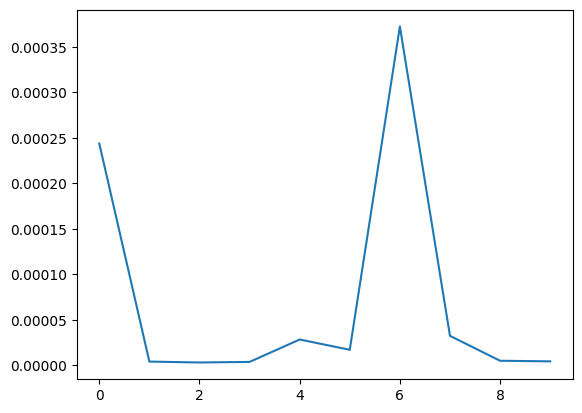

100%|██████████| 10/10 [00:44<00:00,  4.48s/it]


In [5]:
total_rewards = learn_policy(env, 10, policy, 'models_bin/torch.pt')

In [7]:
torch.save(policy.dqn.state_dict(), 'models_bin/torch.pt')